In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from econml.dml import LinearDML
from scipy.stats import shapiro, probplot

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2024-11-17 17:19:31,964	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


The following non-linear dataset is inspired from the linear dataset discussed [here](https://michaelschomaker.github.io/pdf/Preprint_Collider_Schomaker_2018.pdf)

In [2]:
def generate_realistic_data(n=10000, seed=0, beta1=0.5, alpha1=0.4, alpha2=0.3,
                            age_exp= 0.1, sodium_thresh=3.5, bp_base=90, bp_scale=5,
                            noise_sd=10, fixed_vars=None):
    np.random.seed(seed)
    
    # Generate 'age' variable
    if fixed_vars and 'age' in fixed_vars:
        age = np.full(n, fixed_vars['age'])
    else:
        age = np.random.normal(65, 5, n)
    
    # Generate 'sodium' variable
    if fixed_vars and 'sodium' in fixed_vars:
        sodium = np.full(n, fixed_vars['sodium'])
    else:
        sodium = age / 18 + np.random.normal(size=n)
    
    # Exponential effect of age on blood pressure
    age_effect = np.exp(age_exp * (age - 65))
    
    # Adjusted sodium effect
    sodium_effect = np.where(
        sodium < sodium_thresh,
        beta1 * sodium,
        beta1 * sodium + 0.5 * (sodium - sodium_thresh)
    )
    
    # Raw blood pressure calculation
    blood_pressure_raw = sodium_effect + 2 * age_effect
    
    # Scale and shift to realistic blood pressure values (in mmHg)
    blood_pressure = bp_base + bp_scale * blood_pressure_raw + np.random.normal(0, noise_sd, n)
    
    # Generate 'proteinuria' variable
    proteinuria = alpha1 * sodium + alpha2 * blood_pressure + np.random.normal(size=n)
    
    return pd.DataFrame({
        'blood_pressure': blood_pressure,
        'sodium': sodium,
        'age': age,
        'proteinuria': proteinuria
    })

Data = generate_realistic_data(n=10000, seed=0, beta1=0.5, alpha1=0.4, alpha2=0.3, age_exp=0.1, sodium_thresh=3.5, bp_base=90, bp_scale=5,noise_sd=10, fixed_vars=None)

Data.head()

,blood_pressure,sodium,age,proteinuria
0,128.203398,3.899009,73.820262,40.391855
1,109.432775,2.889035,67.000786,34.290230
2,133.826939,5.616583,69.893690,42.898840
3,138.315522,4.424230,76.204466,43.399648
4,101.411913,3.952067,74.337790,32.658159


**The following demonstrates that assuming the joint and conditional distributions of sodium and age are normal is reasonable.**

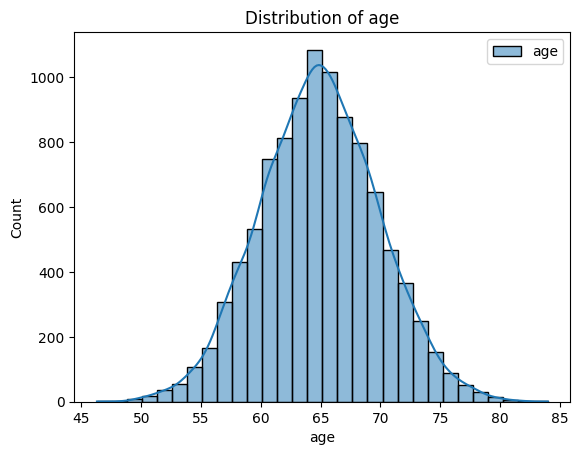

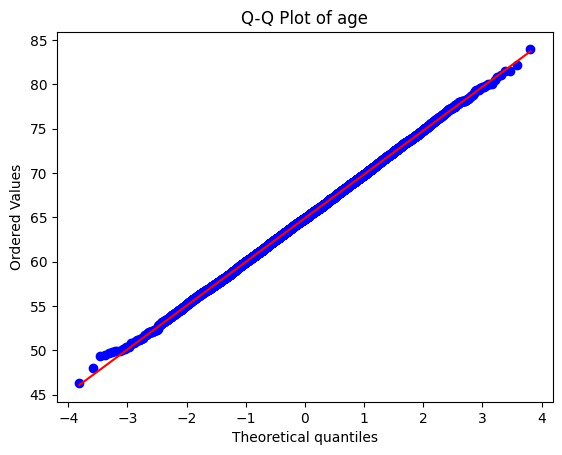

Shapiro-Wilk Test for age: p-value = 0.7522112727165222


p-value may not be accurate for N > 5000.


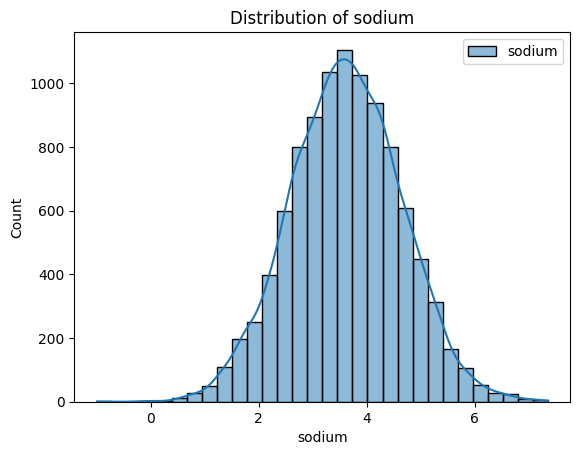

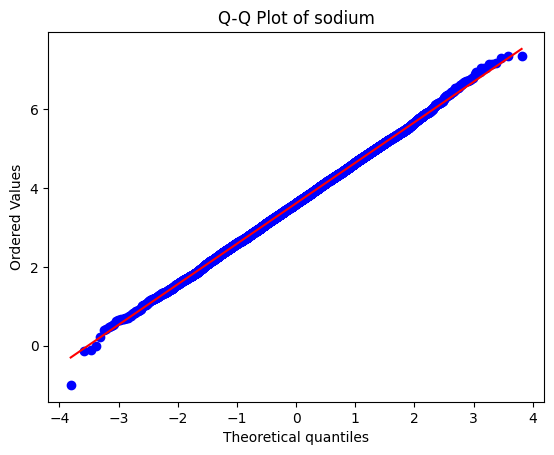

Shapiro-Wilk Test for sodium: p-value = 0.28199502825737


p-value may not be accurate for N > 5000.


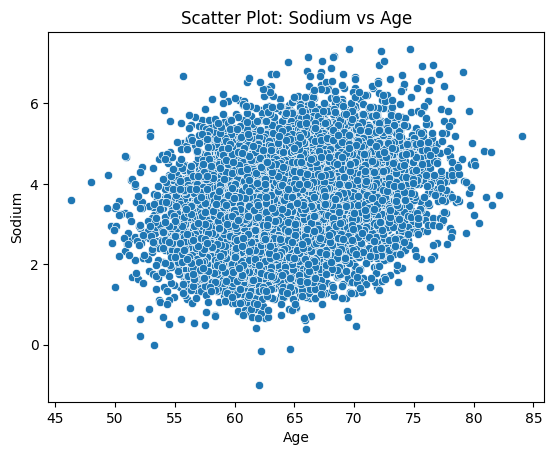

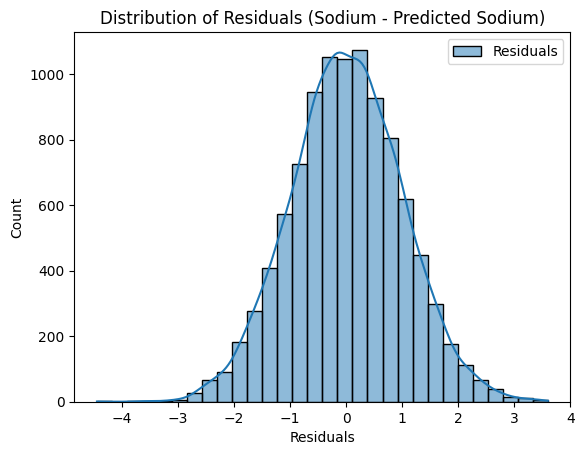

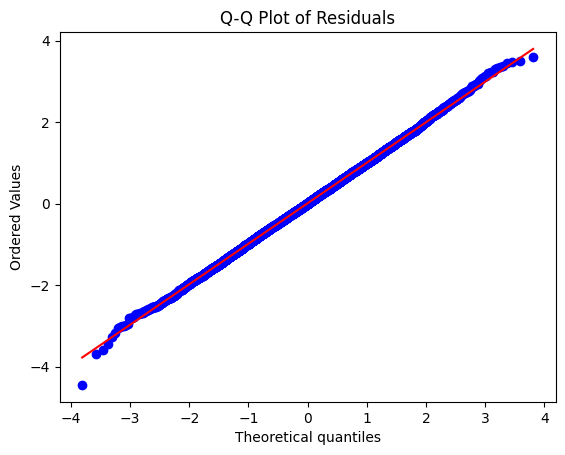

Shapiro-Wilk Test for Residuals: p-value = 0.41160738468170166


p-value may not be accurate for N > 5000.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


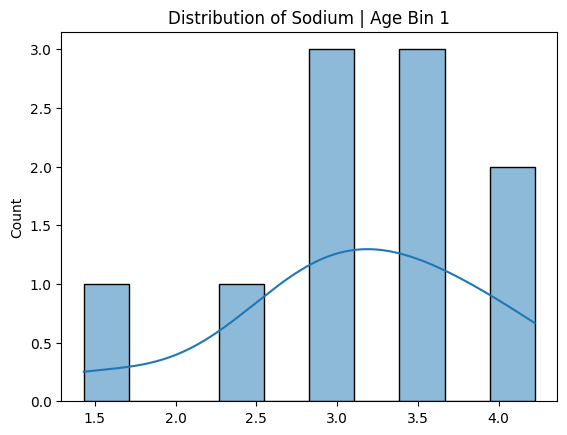

Shapiro-Wilk Test for Sodium | Age Bin 1: p-value = 0.6026015281677246


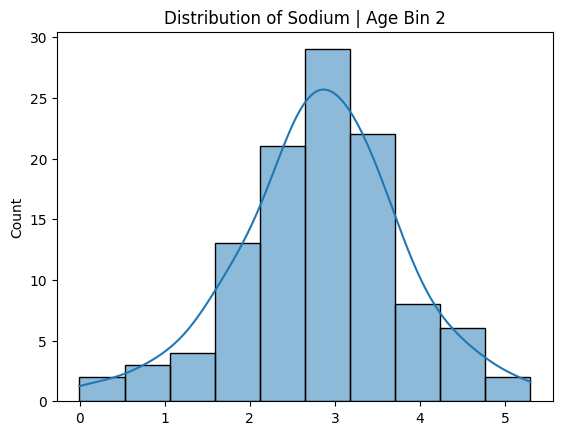

Shapiro-Wilk Test for Sodium | Age Bin 2: p-value = 0.3770712912082672


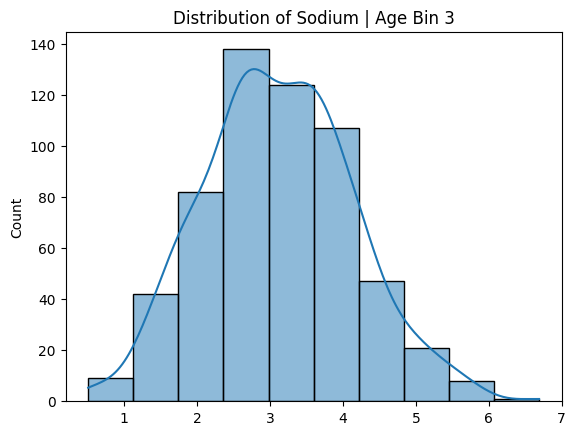

Shapiro-Wilk Test for Sodium | Age Bin 3: p-value = 0.246047705411911


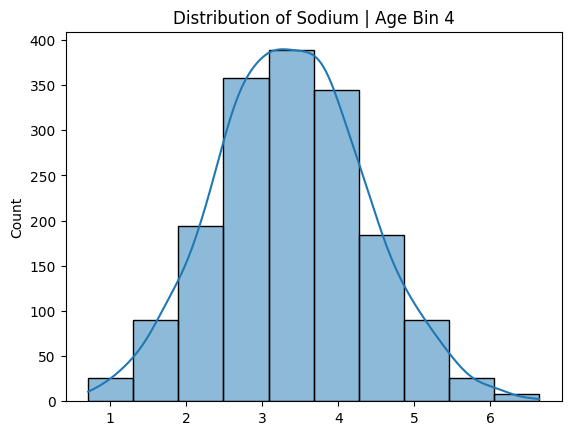

Shapiro-Wilk Test for Sodium | Age Bin 4: p-value = 0.150718092918396


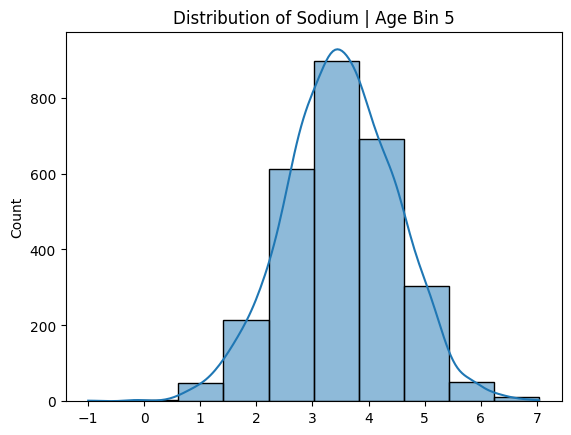

Shapiro-Wilk Test for Sodium | Age Bin 5: p-value = 0.19414298236370087


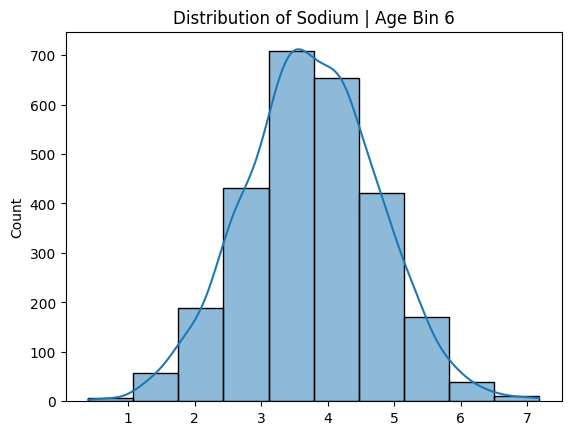

Shapiro-Wilk Test for Sodium | Age Bin 6: p-value = 0.7365646958351135


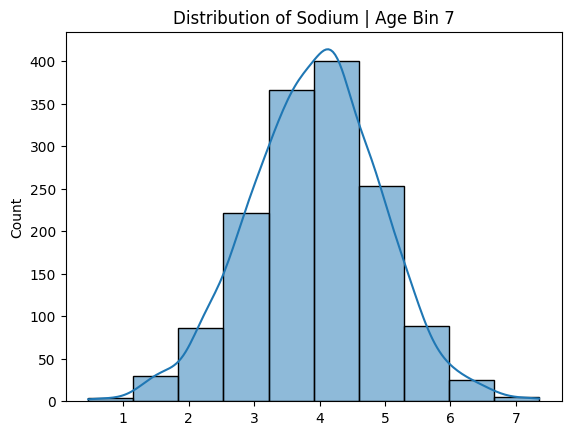

Shapiro-Wilk Test for Sodium | Age Bin 7: p-value = 0.3966524004936218


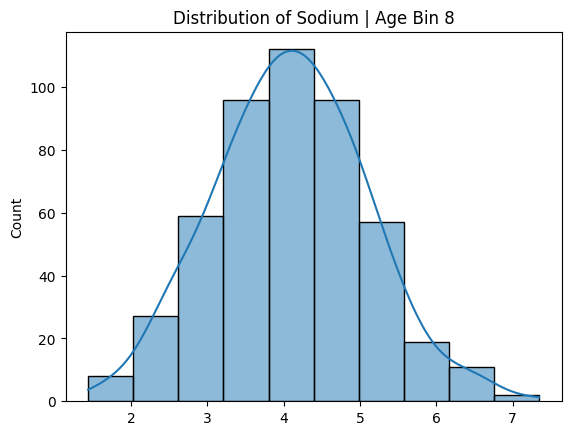

Shapiro-Wilk Test for Sodium | Age Bin 8: p-value = 0.8096205592155457


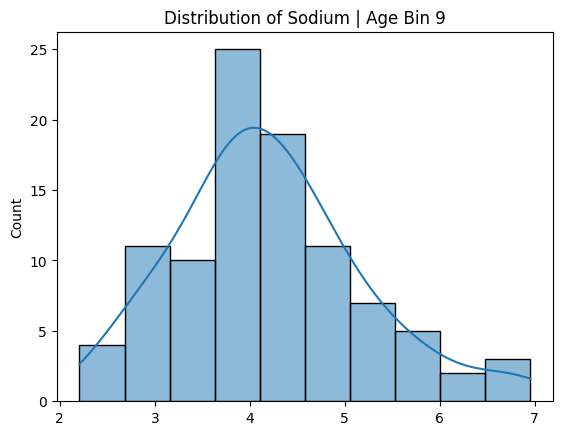

Shapiro-Wilk Test for Sodium | Age Bin 9: p-value = 0.06125681474804878


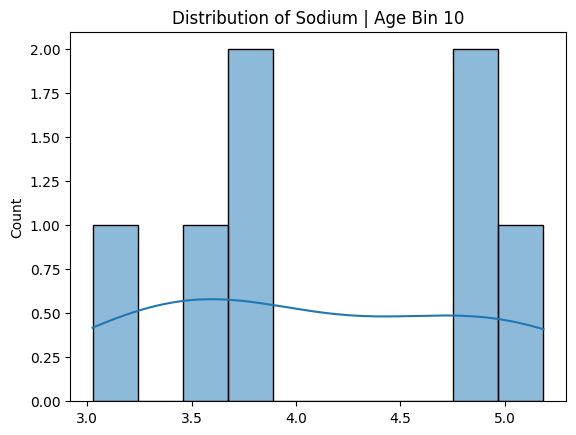

Shapiro-Wilk Test for Sodium | Age Bin 10: p-value = 0.35748717188835144


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


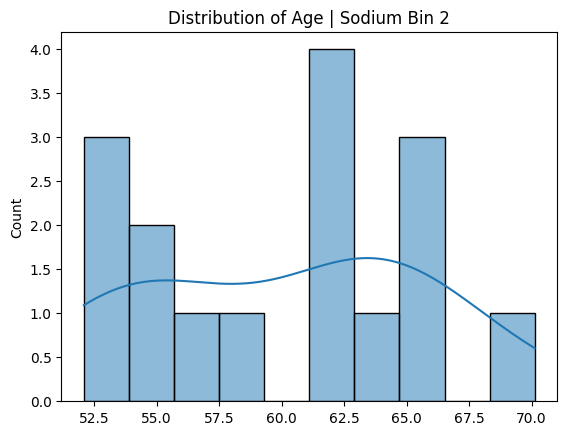

Shapiro-Wilk Test for Age | Sodium Bin 2: p-value = 0.26778993010520935


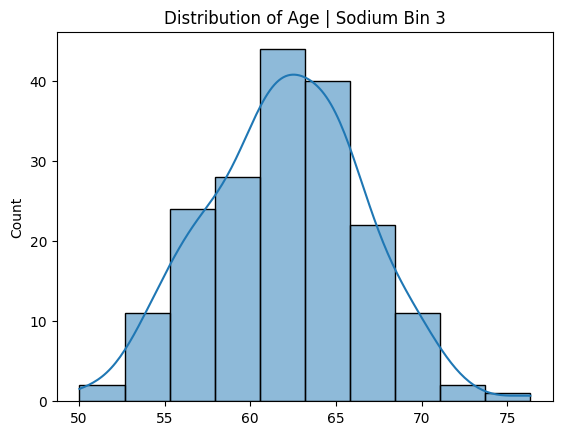

Shapiro-Wilk Test for Age | Sodium Bin 3: p-value = 0.9398269653320312


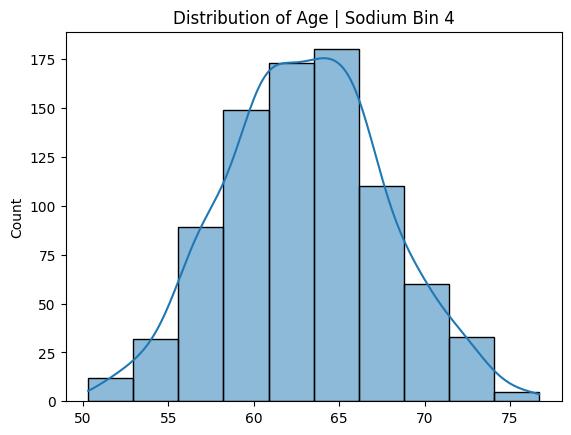

Shapiro-Wilk Test for Age | Sodium Bin 4: p-value = 0.43029674887657166


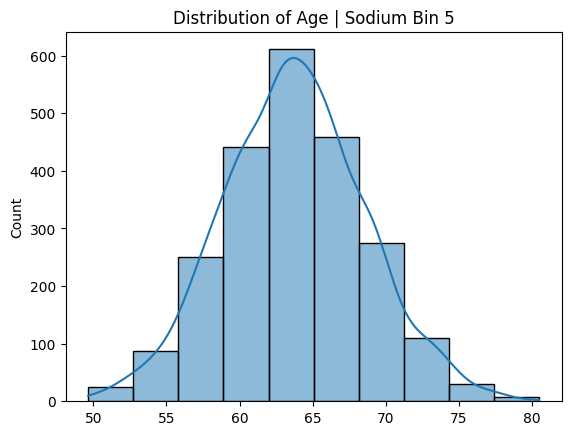

Shapiro-Wilk Test for Age | Sodium Bin 5: p-value = 0.19015255570411682


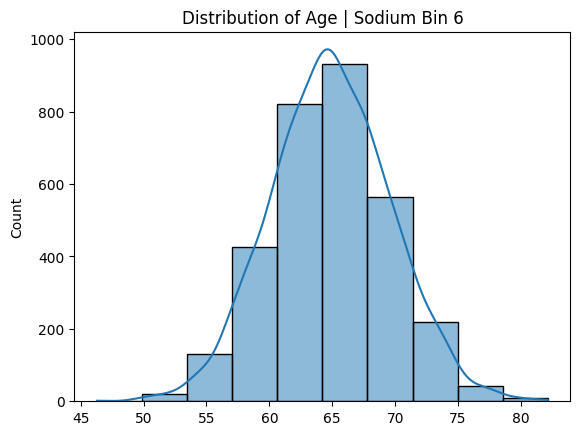

Shapiro-Wilk Test for Age | Sodium Bin 6: p-value = 0.7690619230270386


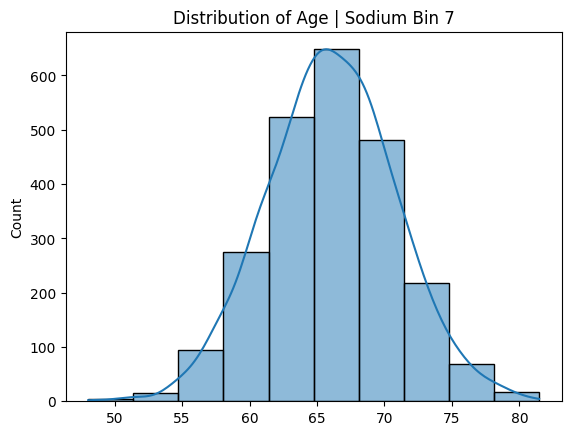

Shapiro-Wilk Test for Age | Sodium Bin 7: p-value = 0.9167841672897339


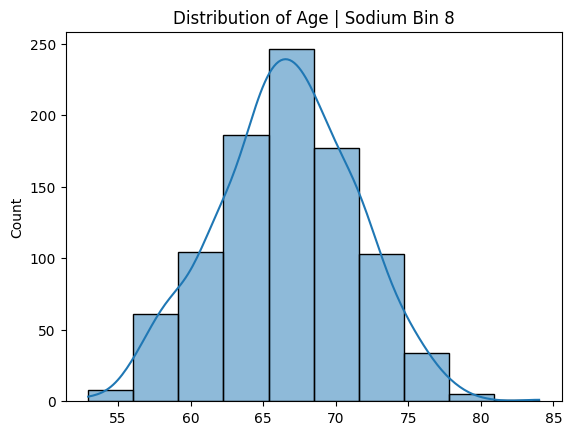

Shapiro-Wilk Test for Age | Sodium Bin 8: p-value = 0.18624424934387207


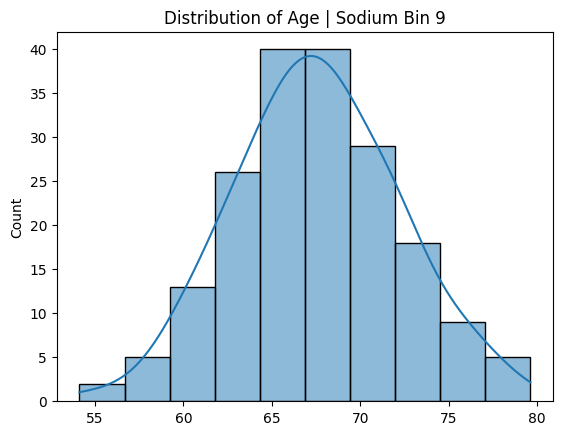

Shapiro-Wilk Test for Age | Sodium Bin 9: p-value = 0.9975743293762207


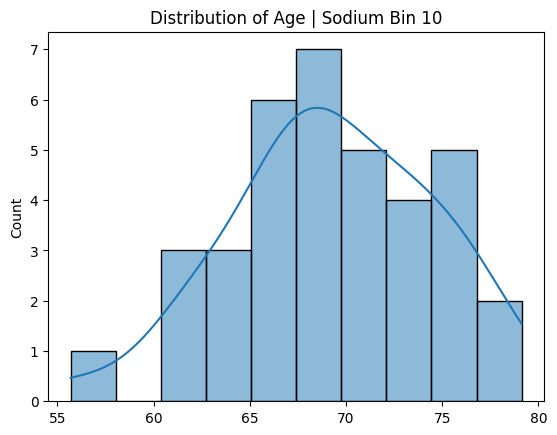

Shapiro-Wilk Test for Age | Sodium Bin 10: p-value = 0.8037953972816467


In [3]:
# Marginal Normality
for var in ['age', 'sodium']:
    sns.histplot(Data[var], kde=True, bins=30, label=f'{var}')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.legend()
    plt.show()

    probplot(Data[var], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {var}")
    plt.show()

    stat, p_value = shapiro(Data[var])
    print(f"Shapiro-Wilk Test for {var}: p-value = {p_value}")

# Joint Normality (Scatter Plot)
sns.scatterplot(x=Data['age'], y=Data['sodium'])
plt.title("Scatter Plot: Sodium vs Age")
plt.xlabel("Age")
plt.ylabel("Sodium")
plt.show()

# Residuals to test joint normality
sodium_pred = Data['age'] / 18  # Linear relationship used to generate sodium
residuals = Data['sodium'] - sodium_pred

sns.histplot(residuals, kde=True, bins=30, label='Residuals')
plt.title("Distribution of Residuals (Sodium - Predicted Sodium)")
plt.xlabel("Residuals")
plt.legend()
plt.show()

probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test for Residuals: p-value = {p_value}")

# Conditional Normality
# Sodium given Age
age_bins = pd.cut(Data['age'], bins=10)  # Bin age for conditional sampling
sodium_given_age = Data.groupby(age_bins)['sodium'].apply(list)

for i, group in enumerate(sodium_given_age):
    if len(group) > 5:  # Ensure enough samples for meaningful test
        sns.histplot(group, kde=True, bins=10)
        plt.title(f"Distribution of Sodium | Age Bin {i+1}")
        plt.show()

        stat, p_value = shapiro(group)
        print(f"Shapiro-Wilk Test for Sodium | Age Bin {i+1}: p-value = {p_value}")

# Age given Sodium
sodium_bins = pd.cut(Data['sodium'], bins=10)  # Bin sodium for conditional sampling
age_given_sodium = Data.groupby(sodium_bins)['age'].apply(list)

for i, group in enumerate(age_given_sodium):
    if len(group) > 5:  # Ensure enough samples for meaningful test
        sns.histplot(group, kde=True, bins=10)
        plt.title(f"Distribution of Age | Sodium Bin {i+1}")
        plt.show()

        stat, p_value = shapiro(group)
        print(f"Shapiro-Wilk Test for Age | Sodium Bin {i+1}: p-value = {p_value}")


In [4]:
import numpy as np
import pandas as pd

def marginal_effects_joint(
    generative_model, num_samples=10000, columns=None, max_points=100, seed=0
):
    """
    Computes the joint marginal causal effects of specified variables on blood pressure.

    Parameters:
    - generative_model: The data-generating function.
    - num_samples: Number of samples to generate at each point.
    - columns: List of variables to compute marginal effects for (expects exactly two variables).
    - max_points: Number of points to evaluate for each variable.
    - seed: Random seed for reproducibility.

    Returns:
    - A dictionary containing grids of variable values and corresponding mean blood pressures.
    """
    # Generate initial data to get variable ranges
    X = generative_model(num_samples)
    if columns is None:
        columns = ['age', 'sodium']
    if len(columns) != 2:
        raise ValueError("This function is designed to compute joint marginal effects for exactly two variables.")
    
    # Get the range of each variable
    x1_values = np.linspace(X[columns[0]].min(), X[columns[0]].max(), max_points)
    x2_values = np.linspace(X[columns[1]].min(), X[columns[1]].max(), max_points)
    
    # Initialize a grid for the results
    mean_bp_grid = np.zeros((max_points, max_points))
    
    for i, x1 in enumerate(x1_values):
        for j, x2 in enumerate(x2_values):
            # Fix both variables to specific values
            fixed_vars = {columns[0]: x1, columns[1]: x2}
            Xnew = generative_model(num_samples, fixed_vars=fixed_vars, seed=seed)
            # Compute the mean blood pressure for this combination
            mean_bp_grid[i, j] = Xnew['blood_pressure'].mean()
    
    # Store results in a dictionary for easy access
    result = {
        'x1_values': x1_values,
        'x2_values': x2_values,
        'mean_blood_pressure': mean_bp_grid,
        'x1_name': columns[0],
        'x2_name': columns[1]
    }
    return result

# Compute joint marginal effects of 'age' and 'sodium' on 'blood_pressure'
marginal_results_joint = marginal_effects_joint(generate_realistic_data)

# Display the result
marginal_results_joint

{'x1_values': array([46.29949681, 46.68039382, 47.06129084, 47.44218785, 47.82308486,
        48.20398187, 48.58487889, 48.9657759 , 49.34667291, 49.72756993,
        50.10846694, 50.48936395, 50.87026096, 51.25115798, 51.63205499,
        52.012952  , 52.39384901, 52.77474603, 53.15564304, 53.53654005,
        53.91743707, 54.29833408, 54.67923109, 55.0601281 , 55.44102512,
        55.82192213, 56.20281914, 56.58371616, 56.96461317, 57.34551018,
        57.72640719, 58.10730421, 58.48820122, 58.86909823, 59.24999524,
        59.63089226, 60.01178927, 60.39268628, 60.7735833 , 61.15448031,
        61.53537732, 61.91627433, 62.29717135, 62.67806836, 63.05896537,
        63.43986239, 63.8207594 , 64.20165641, 64.58255342, 64.96345044,
        65.34434745, 65.72524446, 66.10614147, 66.48703849, 66.8679355 ,
        67.24883251, 67.62972953, 68.01062654, 68.39152355, 68.77242056,
        69.15331758, 69.53421459, 69.9151116 , 70.29600861, 70.67690563,
        71.05780264, 71.43869965, 71.8

In [5]:
sodium_values  = marginal_results_joint['x2_values']
age_values = marginal_results_joint['x1_values']
marginal_results = marginal_results_joint['mean_blood_pressure']

In [6]:
# Calculating the joint probability density function of "sodium" and "age".
mean_sodium_age = Data[['sodium', 'age']].mean().to_numpy()
cov_sodium_age = Data[['sodium', 'age']].cov().to_numpy()
distribution_sodium_age = multivariate_normal(mean = mean_sodium_age, cov = cov_sodium_age)
def Density_sodium_and_age(sodium,age):
  return  distribution_sodium_age.pdf(np.dstack((sodium, age)))

# Calculating the probability density function of "sodium".
mean_sodium = Data[['sodium']].mean().to_numpy()[0]
cov_sodium = Data[['sodium']].cov().to_numpy()[0][0]
def Density_sodium(sodium):
  return  (1/sqrt(2*pi*cov_sodium))*exp(-(1/(2*cov_sodium))*((sodium-mean_sodium)**2))

# Calculating the probability density function of "age".
mean_age = Data[['age']].mean().to_numpy()[0]
cov_age = Data[['age']].cov().to_numpy()[0][0]
def Density_age(age):
  return  (1/sqrt(2*pi*cov_age))*exp(-(1/(2*cov_age))*((age-mean_age)**2))

# Calculating the conditional probability density function of "sodium" given "age".
def Density_sodium_given_age(sodium,age):
  return Density_sodium_and_age(sodium,age)/Density_age(age)

# Calculating the conditional probability density function of "age" given "sodium".
def Density_age_given_sodium(age,sodium):
  return Density_sodium_and_age(sodium,age)/Density_sodium(sodium)

Let $S$, $A$ and $B$ stand for the sodium intake, the age, and the blood preasure, respectively. Also, let $B=g(S,A)$. Then, if $g_{in}$ denotes the function $g$ where we have intervened on both values of $S$ and $A$, then we have that
\begin{equation}
\overline{\mathbb{P}\mathbb{E}\mathbb{A}\mathbb{C}\mathbb{E}}_d(S\to B)=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\left|\frac{\partial g_{in}}{\partial s}(s,a)\right|p_d(s\mid a)f(a)\,\mathrm{d}s\mathrm{d}a,\quad p_d(s\mid a)=\frac{f(s\mid a)^{2d}}{\int_{-\infty}^{\infty}f(s'\mid a)^{2d}\,\mathrm{d}s'}.
\end{equation}
Similarly, we have that
\begin{equation}
\overline{\mathbb{P}\mathbb{E}\mathbb{A}\mathbb{C}\mathbb{E}}_d(A\to B)=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\left|\frac{\partial g_{in}}{\partial a}(s,a)\right|q_d(a\mid s)f(s)\,\mathrm{d}s\mathrm{d}a,\quad q_d(a\mid s)=\frac{f(a\mid s)^{2d}}{\int_{-\infty}^{\infty}f(a'\mid s)^{2d}\,\mathrm{d}a'}.
\end{equation}
Also,
\begin{equation}
\overline{\mathbb{P}\mathbb{E}\mathbb{A}\mathbb{C}\mathbb{E}}_d((S,A)\to B)=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\left|\nabla g_{in}(s,a)\right|f_d(s,a)\,\mathrm{d}s\mathrm{d}a,\quad f_d( s, a)=\frac{f(s,a)^{2d}}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}f(s',a')^{2d}\,\mathrm{d}s'\mathrm{d}a'}.
\end{equation}

In [7]:
# Calculating the Mean PEACE of degree d of "sodium" on "blood preasure".
def Mean_PEACE_sodium_to_blood_pressure(d,r):
  def availability_sodium(j):
    effect_availability = 0
    for i in range(1, len(sodium_values)):
      effect_availability += (sodium_values[i] - sodium_values[i-1]) * ((Density_sodium_given_age(sodium_values[i],age_values[j])* (Density_sodium_given_age(sodium_values[i-1],age_values[j])))**d)
    return effect_availability
  def Mean_PIEV_sodium_to_blood_pressure(j):
    effect_piev = 0
    for i in range(1, len(sodium_values)):
      effect_piev += abs(marginal_results[j][i] - marginal_results[j][i-1]) * ((Density_sodium_given_age(sodium_values[i],age_values[j])* (Density_sodium_given_age(sodium_values[i-1],age_values[j])))**d)
    return effect_piev/availability_sodium(j)
  def new_density_age(j):
    sum_of_degree_r = 0
    for k in range(1, len(age_values)):
      sum_of_degree_r += (Density_age(age_values[k]) **r) * (age_values[k] - age_values[k-1])
    return (Density_age(age_values[j])**r)/sum_of_degree_r
  effect_peace = 0
  for j in range(1, len(age_values)):
    effect_peace += new_density_age(j) * Mean_PIEV_sodium_to_blood_pressure(j) * (age_values[j] - age_values[j-1])
  return effect_peace

# Calculating the Mean PEACE of degree d of "age" on "blood preasure".
def Mean_PEACE_age_to_blood_pressure(d,r):
  def availability_age(i):
    effect_availability = 0
    for j in range(1, len(age_values)):
      effect_availability += (age_values[j] - age_values[j-1]) * ((Density_age_given_sodium(age_values[j],sodium_values[i]) * Density_age_given_sodium(age_values[j-1],sodium_values[i]))**d)
    return effect_availability
  def Mean_PIEV_age_to_blood_pressure(i):
    effect_piev = 0
    for j in range(1, len(age_values)):
      effect_piev += abs(marginal_results[j][i] - marginal_results[j-1][i]) * ((Density_age_given_sodium(age_values[j],sodium_values[i]) * Density_age_given_sodium(age_values[j-1],sodium_values[i]))**d)
    return effect_piev/availability_age(i)
  def new_density_sodium(i):
    sum_of_degree_r = 0
    for k in range(1, len(sodium_values)):
      sum_of_degree_r += (Density_sodium(sodium_values[k]) **r) * (sodium_values[k] - sodium_values[k-1])
    return (Density_sodium(sodium_values[i])**r)/sum_of_degree_r
  effect_peace = 0
  for i in range(1, len(sodium_values)):
    effect_peace += new_density_sodium(i) * Mean_PIEV_age_to_blood_pressure(i) * (sodium_values[i] - sodium_values[i-1])
  return effect_peace

# Calculating the Mean PEACE of degree d of "(age, sodium)" on "blood preasure".
def Mean_PEACE_age_and_sodium_to_blood_pressure(d):
    effect_availability = 0
    for j in range(1, len(age_values)):
      for i in range(1, len(sodium_values)):
        effect_availability += (age_values[j] - age_values[j-1]) * (sodium_values[i] - sodium_values[i-1]) * ((Density_sodium_and_age(sodium_values[i],age_values[j]) * (Density_sodium_and_age(sodium_values[i-1],age_values[j-1])))**d)
   
    effect_peace = 0
    for j in range(1, len(age_values)):
      for i in range(1, len(sodium_values)):
        effect_peace += (sodium_values[i] - sodium_values[i-1]) * (age_values[j] - age_values[j-1]) * np.sqrt(((marginal_results[j][i] - marginal_results[j-1][i])/((age_values[j] - age_values[j-1])))**2 + ((marginal_results[j][i] - marginal_results[j][i-1])/(sodium_values[i] - sodium_values[i-1]))**2) * ((Density_sodium_and_age(sodium_values[i],age_values[j]) * (Density_sodium_and_age(sodium_values[i-1],age_values[j-1])))**d)
    return effect_peace/effect_availability

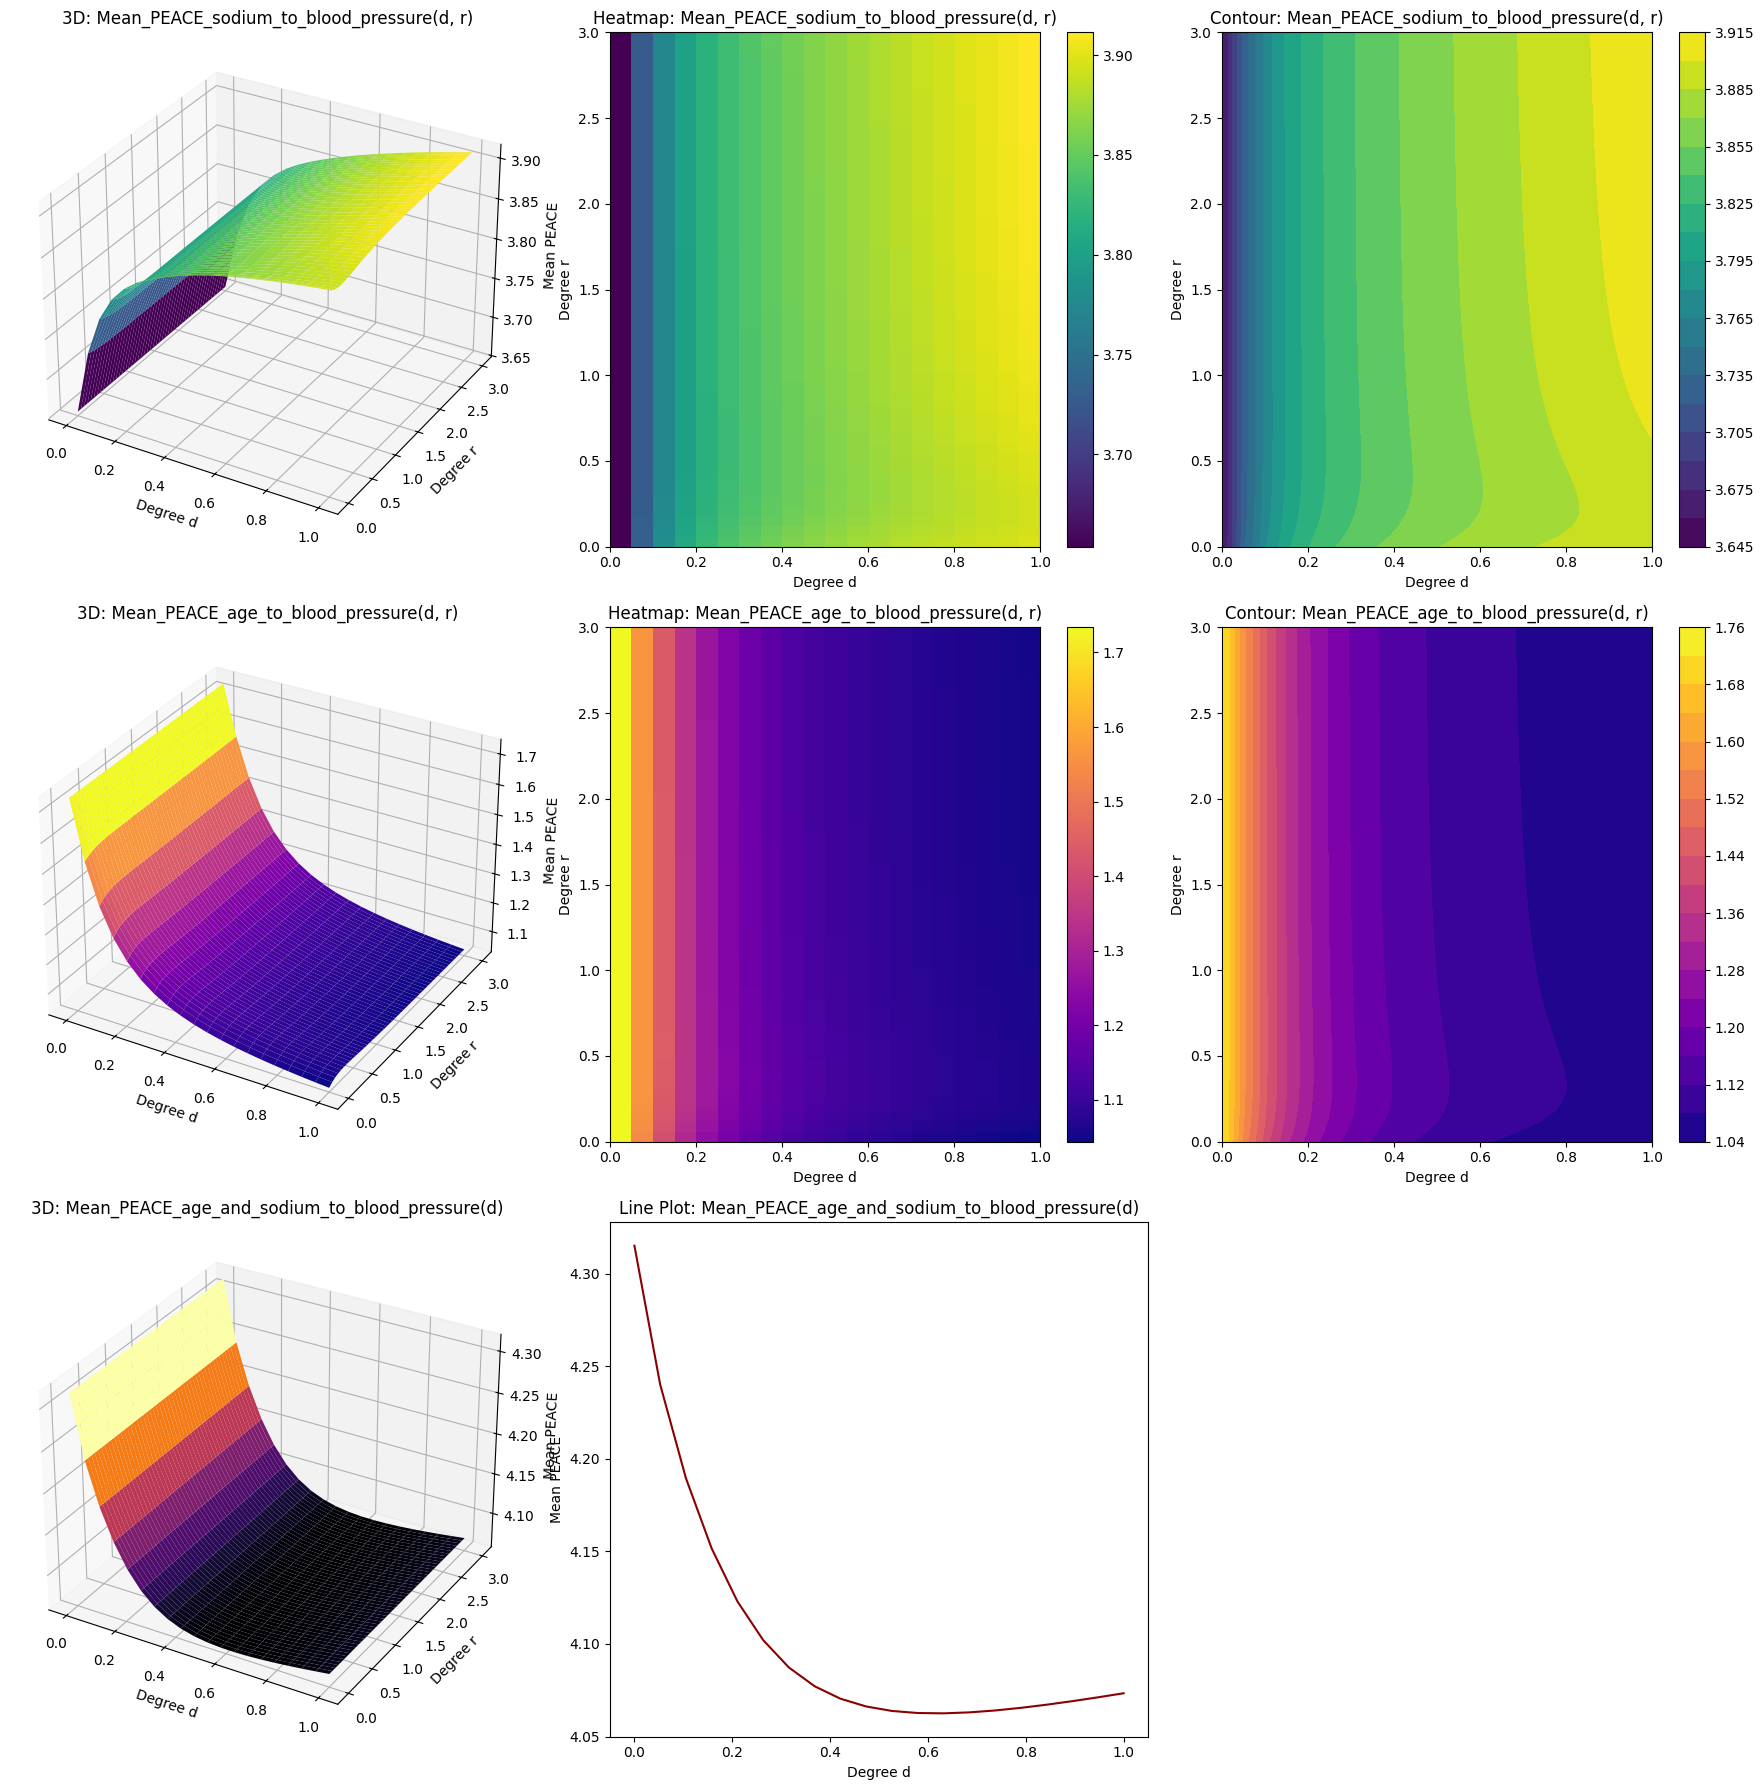

In [8]:
def calculate_Z_sodium(params):
    d, r = params
    return Mean_PEACE_sodium_to_blood_pressure(d, r)

def calculate_Z_age(params):
    d, r = params
    return Mean_PEACE_age_to_blood_pressure(d, r)

# Define ranges for d and r
d_values = np.linspace(0, 1, 20)
r_values = np.linspace(0, 3, 50)

# Initialize grids for plotting
D, R = np.meshgrid(d_values, r_values)

# Use multiprocessing Pool to parallelize the calculation of Z_sodium and Z_age
with Pool() as pool:
    params_list = [(d, r) for r in r_values for d in d_values]
    Z_sodium = np.array(pool.map(calculate_Z_sodium, params_list)).reshape(len(r_values), len(d_values))
    Z_age = np.array(pool.map(calculate_Z_age, params_list)).reshape(len(r_values), len(d_values))

# Calculate Z_age_sodium, which only depends on d (not r)
Z_age_sodium = np.array([Mean_PEACE_age_and_sodium_to_blood_pressure(d) for d in d_values])

# Adjust Z_age_sodium shape to match the meshgrid dimensions of D and R for 2D heatmap/contour
Z_age_sodium_expanded = np.tile(Z_age_sodium, (len(r_values), 1))

# Plotting each function
fig = plt.figure(figsize=(18, 18))

# Row 1: Mean_PEACE_sodium_to_blood_pressure (sodium)
# 3D Surface Plot for Mean_PEACE_sodium_to_blood_pressure
ax1 = fig.add_subplot(331, projection='3d')
ax1.plot_surface(D, R, Z_sodium, cmap='viridis')
ax1.set_title("3D: Mean_PEACE_sodium_to_blood_pressure(d, r)")
ax1.set_xlabel("Degree d")
ax1.set_ylabel("Degree r")
ax1.set_zlabel("Mean PEACE")

# Heatmap for Mean_PEACE_sodium_to_blood_pressure
ax2 = fig.add_subplot(332)
c1 = ax2.imshow(Z_sodium, extent=[d_values.min(), d_values.max(), r_values.min(), r_values.max()],
                aspect='auto', origin='lower', cmap='viridis')
ax2.set_title("Heatmap: Mean_PEACE_sodium_to_blood_pressure(d, r)")
ax2.set_xlabel("Degree d")
ax2.set_ylabel("Degree r")
fig.colorbar(c1, ax=ax2)

# Contour Plot for Mean_PEACE_sodium_to_blood_pressure
ax3 = fig.add_subplot(333)
c2 = ax3.contourf(D, R, Z_sodium, 20, cmap='viridis')
ax3.set_title("Contour: Mean_PEACE_sodium_to_blood_pressure(d, r)")
ax3.set_xlabel("Degree d")
ax3.set_ylabel("Degree r")
fig.colorbar(c2, ax=ax3)

# Row 2: Mean_PEACE_age_to_blood_pressure (age)
# 3D Surface Plot for Mean_PEACE_age_to_blood_pressure
ax4 = fig.add_subplot(334, projection='3d')
ax4.plot_surface(D, R, Z_age, cmap='plasma')
ax4.set_title("3D: Mean_PEACE_age_to_blood_pressure(d, r)")
ax4.set_xlabel("Degree d")
ax4.set_ylabel("Degree r")
ax4.set_zlabel("Mean PEACE")

# Heatmap for Mean_PEACE_age_to_blood_pressure
ax5 = fig.add_subplot(335)
c3 = ax5.imshow(Z_age, extent=[d_values.min(), d_values.max(), r_values.min(), r_values.max()],
                aspect='auto', origin='lower', cmap='plasma')
ax5.set_title("Heatmap: Mean_PEACE_age_to_blood_pressure(d, r)")
ax5.set_xlabel("Degree d")
ax5.set_ylabel("Degree r")
fig.colorbar(c3, ax=ax5)

# Contour Plot for Mean_PEACE_age_to_blood_pressure
ax6 = fig.add_subplot(336)
c4 = ax6.contourf(D, R, Z_age, 20, cmap='plasma')
ax6.set_title("Contour: Mean_PEACE_age_to_blood_pressure(d, r)")
ax6.set_xlabel("Degree d")
ax6.set_ylabel("Degree r")
fig.colorbar(c4, ax=ax6)

# Row 3: Mean_PEACE_age_and_sodium_to_blood_pressure (joint)
# 3D Surface Plot for Mean_PEACE_age_and_sodium_to_blood_pressure (only varies with d)
ax7 = fig.add_subplot(337, projection='3d')
ax7.plot_surface(D, R, Z_age_sodium_expanded, cmap='inferno')
ax7.set_title("3D: Mean_PEACE_age_and_sodium_to_blood_pressure(d)")
ax7.set_xlabel("Degree d")
ax7.set_ylabel("Degree r")
ax7.set_zlabel("Mean PEACE")

# 2D Line Plot for Mean_PEACE_age_and_sodium_to_blood_pressure
ax8 = fig.add_subplot(338)
ax8.plot(d_values, Z_age_sodium, color='darkred')
ax8.set_title("Line Plot: Mean_PEACE_age_and_sodium_to_blood_pressure(d)")
ax8.set_xlabel("Degree d")
ax8.set_ylabel("Mean PEACE")

plt.tight_layout()
plt.show()

**Other Methods**

**Causal Forest Method**

In [9]:
pip install econml

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


**When we do not know the underlying DAG and assume that proteinuria affect also the blood pressure (that gives us wrong results):**

        sodium        age  proteinuria  blood_pressure  \
9394  3.529432  58.802368    38.920439      126.134985   
898   3.643462  77.972123    42.376232      133.627172   
2398  4.883278  62.015414    34.872099      111.840217   
5906  4.454522  58.591754    36.510717      109.410089   
2343  3.288519  69.310740    33.500582      106.925702   

      estimated_treatment_effect  
9394                   -0.242059  
898                    -0.631938  
2398                   -0.819579  
5906                   -0.622092  
2343                   -0.964768  


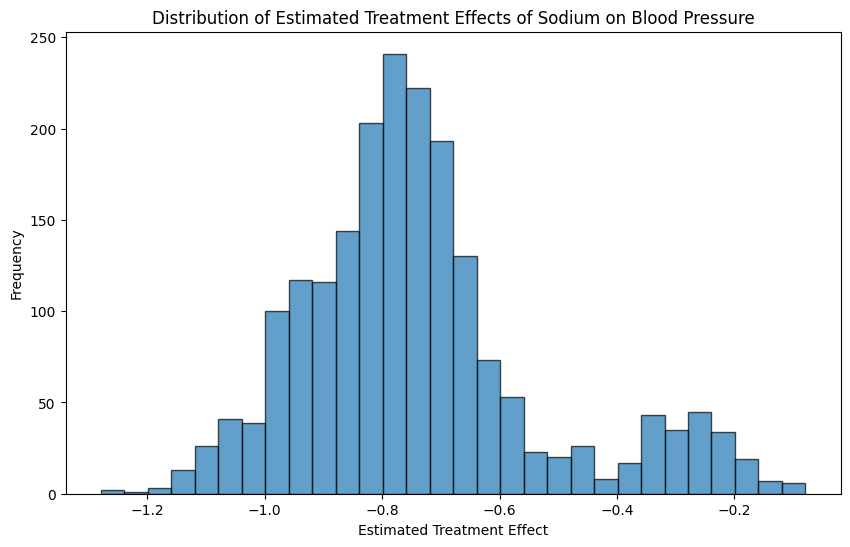

In [10]:
# Import necessary libraries
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(Data, test_size=0.2, random_state=0)

# Define treatment, outcome, and covariates
Y = train_data['blood_pressure']         # Outcome
T = train_data['sodium']                 # Treatment
X = train_data[['age', 'proteinuria']]   # Covariates

# Initialize the Causal Forest model
causal_forest = CausalForestDML(
    model_y=RandomForestRegressor(),       # Model for the outcome
    model_t=RandomForestRegressor(),       # Model for the treatment
    n_estimators=100,                      # Number of trees in the forest
    max_depth=5,                           # Depth of each tree
    min_samples_leaf=10,                   # Minimum samples per leaf
    random_state=0
)

# Fit the model on the training data
causal_forest.fit(Y=Y, T=T, X=X)

# Estimate the treatment effect on the test data
X_test = test_data[['age', 'proteinuria']]  # Test covariates
treatment_effects = causal_forest.effect(X_test)

# Add the estimated treatment effect to the test data for comparison
test_data['estimated_treatment_effect'] = treatment_effects

# Display the first few rows with the estimated treatment effect
print(test_data[['sodium', 'age', 'proteinuria', 'blood_pressure', 'estimated_treatment_effect']].head())

# Plot the distribution of the estimated treatment effect
plt.figure(figsize=(10, 6))
plt.hist(treatment_effects, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Estimated Treatment Effects of Sodium on Blood Pressure')
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Frequency')
plt.show()

**When we know the underlying DAG, and we assume that proteinuria does not affect blood pressure:**

        sodium        age  blood_pressure  estimated_sodium_effect  \
9394  3.529432  58.802368      126.134985                 4.043295   
898   3.643462  77.972123      133.627172                 3.094603   
2398  4.883278  62.015414      111.840217                 3.719325   
5906  4.454522  58.591754      109.410089                 4.099845   
2343  3.288519  69.310740      106.925702                 4.565784   

      estimated_age_effect  
9394              1.233459  
898               1.161844  
2398              1.203119  
5906              1.170688  
2343              1.096173  


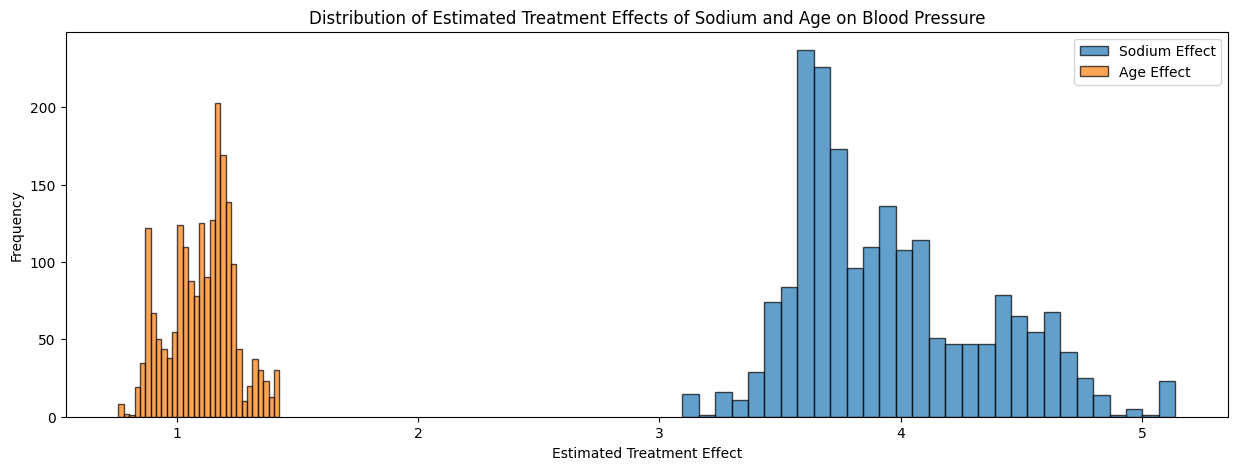

In [11]:
# First model: Sodium as treatment, Age as covariate
Y = train_data['blood_pressure']          # Outcome
T_sodium = train_data['sodium']           # Treatment: Sodium
X_age = train_data[['age']]               # Covariate: Age

# Initialize and fit the causal forest model for sodium
causal_forest_sodium = CausalForestDML(
    model_y=RandomForestRegressor(),       # Model for the outcome
    model_t=RandomForestRegressor(),       # Model for the treatment
    n_estimators=100,                      # Number of trees in the forest
    max_depth=5,                           # Depth of each tree
    min_samples_leaf=10,                   # Minimum samples per leaf
    random_state=0
)
causal_forest_sodium.fit(Y=Y, T=T_sodium, X=X_age)

# Estimate the treatment effect of sodium on blood pressure
X_test_age = test_data[['age']]
sodium_treatment_effects = causal_forest_sodium.effect(X_test_age)

# Second model: Age as treatment, Sodium as covariate
T_age = train_data['age']                 # Treatment: Age
X_sodium = train_data[['sodium']]         # Covariate: Sodium

# Initialize and fit the causal forest model for age
causal_forest_age = CausalForestDML(
    model_y=RandomForestRegressor(),       # Model for the outcome
    model_t=RandomForestRegressor(),       # Model for the treatment
    n_estimators=100,                      # Number of trees in the forest
    max_depth=5,                           # Depth of each tree
    min_samples_leaf=10,                   # Minimum samples per leaf
    random_state=0
)
causal_forest_age.fit(Y=Y, T=T_age, X=X_sodium)

# Estimate the treatment effect of age on blood pressure
X_test_sodium = test_data[['sodium']]
age_treatment_effects = causal_forest_age.effect(X_test_sodium)

# Add the estimated treatment effects to the test data for comparison
test_data['estimated_sodium_effect'] = sodium_treatment_effects
test_data['estimated_age_effect'] = age_treatment_effects

# Display the first few rows with the estimated treatment effects
print(test_data[['sodium', 'age', 'blood_pressure', 'estimated_sodium_effect', 'estimated_age_effect']].head())

# Plot the distribution of the estimated treatment effects for sodium and age
plt.figure(figsize=(15, 5))
plt.hist(sodium_treatment_effects, bins=30, edgecolor='k', alpha=0.7, label='Sodium Effect')
plt.hist(age_treatment_effects, bins=30, edgecolor='k', alpha=0.7, label='Age Effect')
plt.title('Distribution of Estimated Treatment Effects of Sodium and Age on Blood Pressure')
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Double ML Method**

        sodium        age  blood_pressure  estimated_sodium_effect  \
9394  3.529432  58.802368      126.134985                 3.750946   
898   3.643462  77.972123      133.627172                 4.399116   
2398  4.883278  62.015414      111.840217                 3.859586   
5906  4.454522  58.591754      109.410089                 3.743825   
2343  3.288519  69.310740      106.925702                 4.106256   

      estimated_age_effect  
9394              1.116089  
898               1.130514  
2398              1.287352  
5906              1.233114  
2343              1.085614  


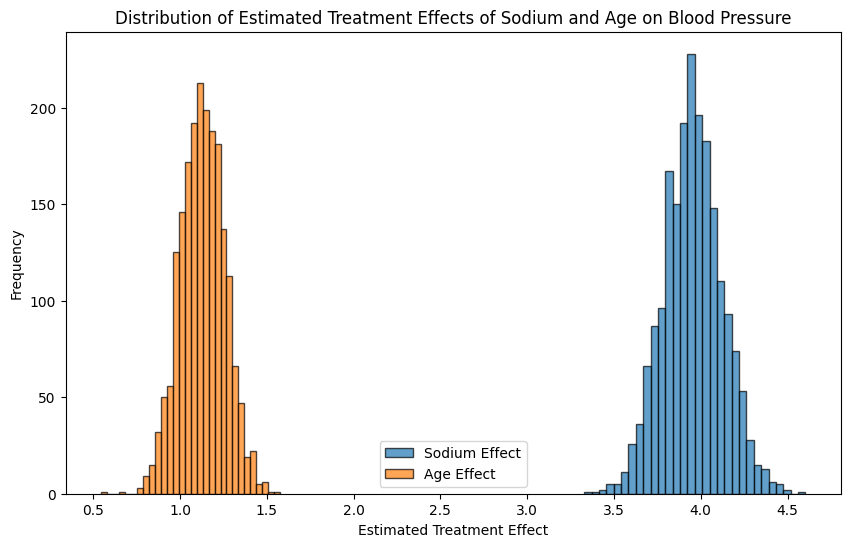

In [12]:
# Generate the dataset
Data = generate_realistic_data(n=10000, seed=0, beta1=0.5, alpha1=0.4, alpha2=0.3, age_exp=0.1, sodium_thresh=3.5, bp_base=90, bp_scale=5, noise_sd=10, fixed_vars=None)

# Split the data into training and testing sets
train_data, test_data = train_test_split(Data, test_size=0.2, random_state=0)

# Define models for the outcome and treatment
model_y = RandomForestRegressor(n_estimators=150, max_depth=10, min_samples_leaf=5, random_state=0)
model_t = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0)

# First model: Sodium as treatment, Age as covariate
Y_train = train_data['blood_pressure']         # Outcome
T_train_sodium = train_data['sodium']          # Treatment: Sodium
X_train_age = train_data[['age']]              # Covariate: Age
X_test_age = test_data[['age']]

# Initialize and fit the LinearDML model for sodium
dml_sodium = LinearDML(
    model_y=model_y,
    model_t=model_t,
    random_state=0,
    cv=5
)
dml_sodium.fit(Y=Y_train, T=T_train_sodium, X=X_train_age)

# Estimate the treatment effect of sodium on blood pressure
sodium_treatment_effects = dml_sodium.effect(X_test_age)

# Second model: Age as treatment, Sodium as covariate
T_train_age = train_data['age']                # Treatment: Age
X_train_sodium = train_data[['sodium']]        # Covariate: Sodium
X_test_sodium = test_data[['sodium']]

# Initialize and fit the LinearDML model for age
dml_age = LinearDML(
    model_y=model_y,
    model_t=model_t,
    random_state=0,
    cv=5
)
dml_age.fit(Y=Y_train, T=T_train_age, X=X_train_sodium)

# Estimate the treatment effect of age on blood pressure
age_treatment_effects = dml_age.effect(X_test_sodium)

# Add the estimated treatment effects to the test data for inspection
test_data['estimated_sodium_effect'] = sodium_treatment_effects
test_data['estimated_age_effect'] = age_treatment_effects

# Display the first few rows with the estimated treatment effects
print(test_data[['sodium', 'age', 'blood_pressure', 'estimated_sodium_effect', 'estimated_age_effect']].head())

# Plot the distribution of the estimated treatment effects for sodium and age
plt.figure(figsize=(10, 6))
plt.hist(sodium_treatment_effects, bins=30, edgecolor='k', alpha=0.7, label='Sodium Effect')
plt.hist(age_treatment_effects, bins=30, edgecolor='k', alpha=0.7, label='Age Effect')
plt.title('Distribution of Estimated Treatment Effects of Sodium and Age on Blood Pressure')
plt.xlabel('Estimated Treatment Effect')
plt.ylabel('Frequency')
plt.legend()
plt.show()
